In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg


c:\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 3.44 s


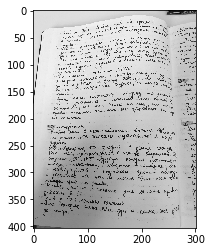

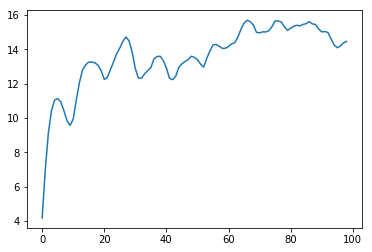

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.5), -90.0-text_angle[0][0], resize=True)

plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

c:\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 3.36 s


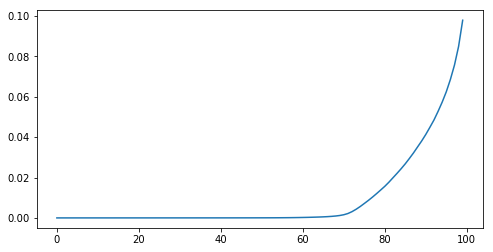

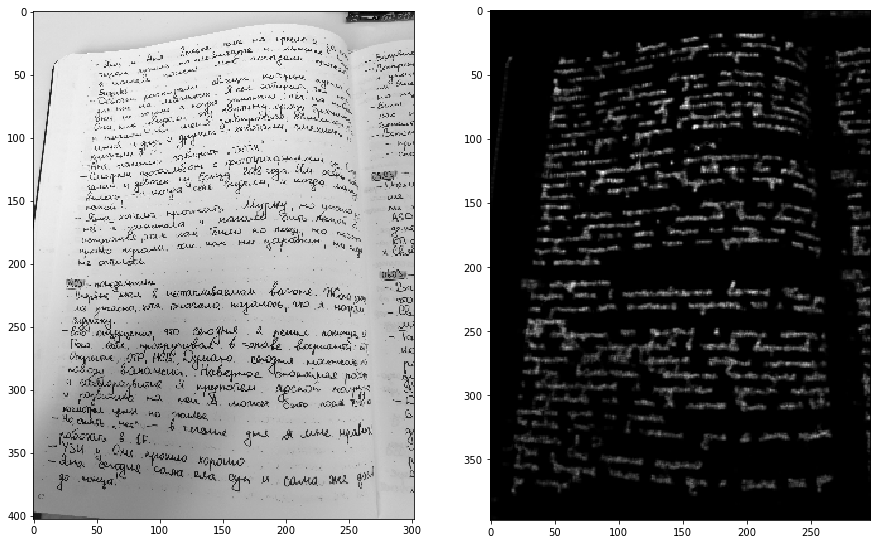

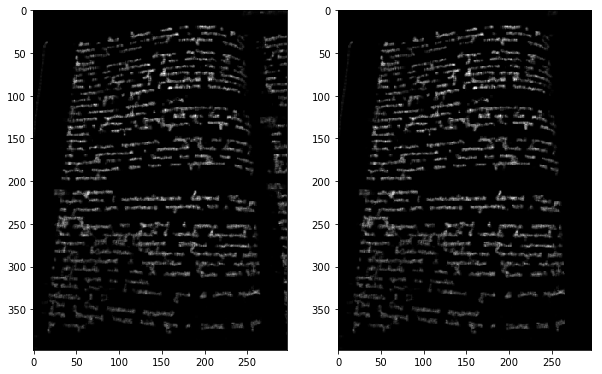

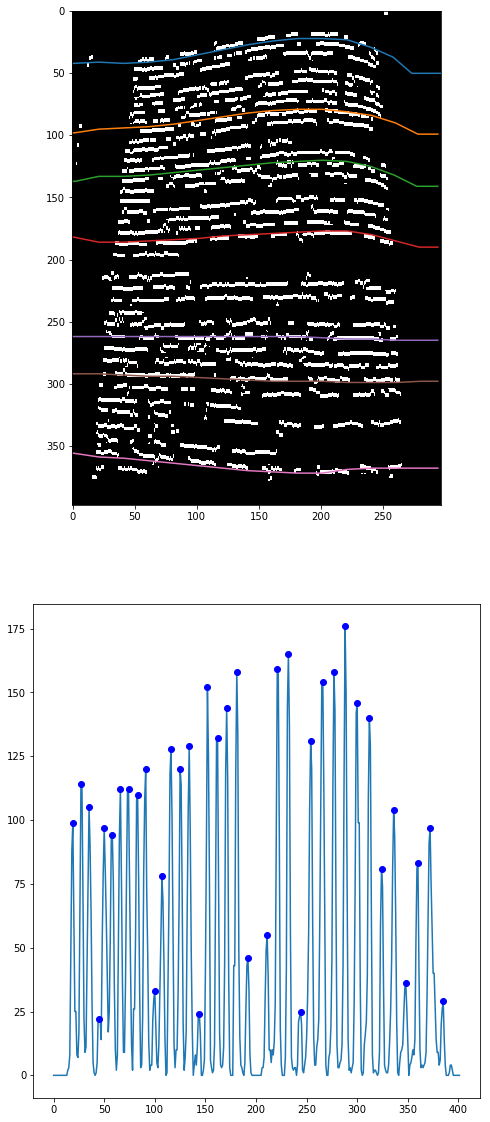

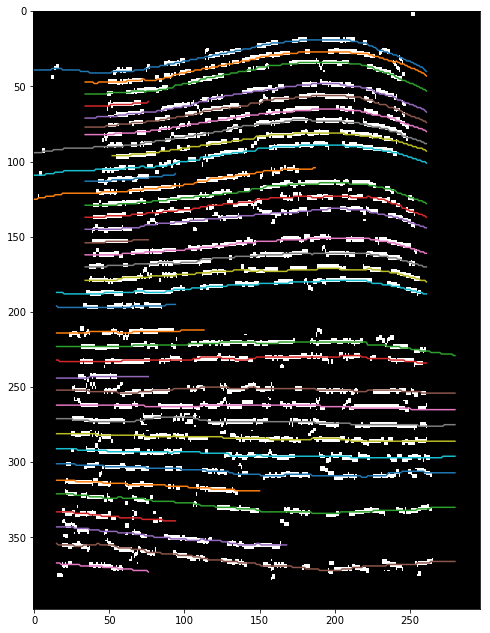

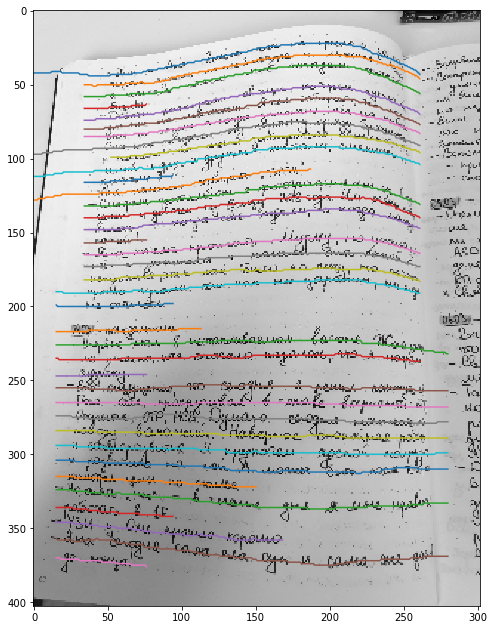

In [3]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)

src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
    res_j, res_i = skew_line.optimize_curve(src8, tmp_j, tmp_i, offset=4, min_window=20)
    all_curves.append((res_j, res_i))

extracted_lines = transform.extract_lines_from_image(srcr, src7, all_curves, text_line_delta, 20, height_margin=0.5)

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')
    
plt.figure(figsize=(8,20))
plt.imshow(src8, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i)
    
plt.figure(figsize=(8,20))
plt.imshow(src3, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i+text_line_delta//4+1)

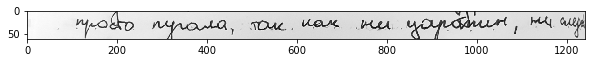

In [159]:
src_l0 = extracted_lines[19][0]
plt.figure(figsize=(10,10))
plt.imshow(src_l0, cmap='gray')

In [160]:
f_x1 = np.cumsum(np.cumsum(src_l0, axis=0), axis=1)
f_x2 = np.cumsum(np.cumsum(np.power(src_l0, 2.0), axis=0), axis=1)
flt_size = 10
nsize = flt_size*flt_size
d_x1 = f_x1[flt_size:,flt_size:]+f_x1[:-flt_size,:-flt_size]-f_x1[:-flt_size,flt_size:]-f_x1[flt_size:,:-flt_size]
d_x2 = f_x2[flt_size:,flt_size:]+f_x2[:-flt_size,:-flt_size]-f_x2[:-flt_size,flt_size:]-f_x2[flt_size:,:-flt_size]
f_f = np.sqrt((d_x2-d_x1*d_x1/nsize)/nsize)

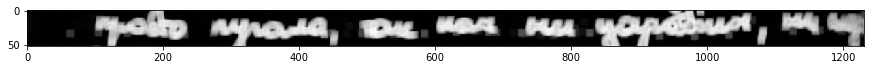

In [161]:
plt.figure(figsize=(15,15))
plt.imshow(f_f, cmap='gray')

In [259]:
def filter_stddev(src, filter_size):
    f_x1 = np.cumsum(np.cumsum(src_l0, axis=0), axis=1)
    f_x2 = np.cumsum(np.cumsum(np.power(src_l0, 2.0), axis=0), axis=1)
    if type(filter_size) is int:
        flt_w = filter_size
        flt_h = filter_size
    else:
        flt_w = filter_size[1]
        flt_h = filter_size[0]
    nsize = flt_w * flt_h
    d_x1 = f_x1[flt_h:,flt_w:]-f_x1[:-flt_h,flt_w:]-f_x1[flt_h:,:-flt_w]+f_x1[:-flt_h,:-flt_w]
    d_x2 = f_x2[flt_h:,flt_w:]-f_x2[:-flt_h,flt_w:]-f_x2[flt_h:,:-flt_w]+f_x2[:-flt_h,:-flt_w]
    return np.sqrt(np.maximum(0,(d_x2 - d_x1*d_x1/nsize))/nsize)

def create_regularization_vector(height, reg_lo, reg_hi, reg_center_pct):
    reg1 = np.abs(np.linspace(0, 1, height) - reg_center_pct)
    reg2 = np.minimum(1.0, reg1 / min(reg1[0], reg1[-1]))
    return np.power(1 - np.power(reg2, reg_hi), reg_lo)

def locate_positive_regions(src):
    #check that there are no zeros or modify array a little:
    if(np.any(src==0)):
        if(np.all(src==0)):
            return []
        delta = 0.5*np.min(np.abs(src[src!=0]))
    else:
        delta = 0
    smd = src + delta
    lends = np.arange(len(smd)-1)[(smd[:-1]<0)&(smd[1:]>0)]
    rends = np.arange(len(smd)-1)[(smd[:-1]>0)&(smd[1:]<0)]+1
    
    if lends[0] > rends[0]:
        rends = np.insert(lends, 0, 0)
    if lends[-1] > rends[-1]:
        rends = np.append(rends, len(smd)-1)
    
    return list(zip(lends, rends+1))

def locate_words(src_line, qntl_window_size=5, reg_vector=None):
    if reg_vector is None:
        rs = src_line
    else:
        rs = np.array([src_line[:,i]*reg_vector for i in range(src_line.shape[1])]).T
    rsmean = np.mean(rs, axis=0)
    plt.plot(rsmean)
    pcts = np.percentile(rsmean, np.arange(81))
    cut_id = np.argmax(pcts[qntl_window_size:]-pcts[:-qntl_window_size])
    cutoff = pcts[cut_id+qntl_window_size//2]
    return locate_positive_regions(rsmean-cutoff)


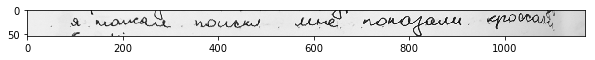

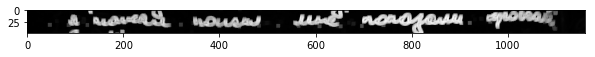

In [260]:
src_l0 = extracted_lines[2][0]
src_c0 = extracted_lines[2][1]
src_off0 = extracted_lines[2][2]
flt_size = 7
f_f = filter_stddev(src_l0, flt_size)

plt.figure(figsize=(10,10))
plt.imshow(src_l0, cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(f_f, cmap='gray')

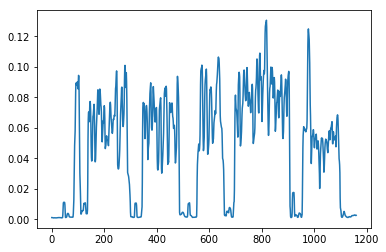

In [261]:
reg_vector = create_regularization_vector(f_f.shape[0], 3.0, 2.0, 0.5)
word_locs = locate_words(f_f, reg_vector=reg_vector)

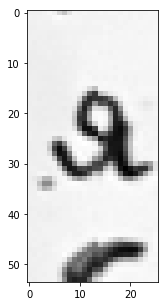

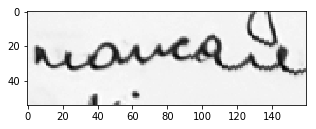

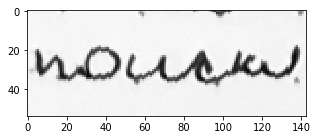

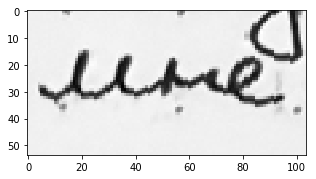

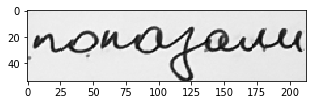

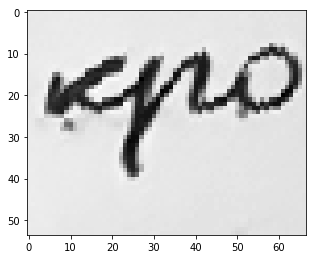

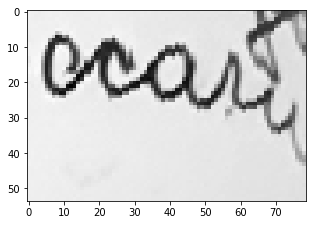

In [262]:
for (j0, j1) in word_locs:
    plt.figure(figsize=(5,5))
    j0 += flt_size//2
    j1 += flt_size//2
    plt.imshow(src_l0[:, j0:j1], cmap='gray')

In [245]:
def calculate_word_curve(curve_l, curve_j, curve_i, word_location, num_points=2):
    interp_l = np.linspace(word_location[0], word_location[1], num_points)
    res_j = np.interp(interp_l, curve_l, curve_j)
    res_i = np.interp(interp_l, curve_l, curve_i)
    return res_j, res_i

def calculate_word_bbox(curve_l, curve_j, curve_i, word_location, offsets):
    tmp_j, tmp_i = calculate_word_curve(curve_l, curve_j, curve_i, word_location, num_points=2)
    c0 = np.array([tmp_i[0], tmp_j[0]])
    c1 = np.array([tmp_i[1], tmp_j[1]])
    p0 = np.array([c0[0]+offsets[0], c0[1]])
    p1 = np.array([c1[0]+offsets[0], c1[1]])
    p2 = np.array([c1[0]+offsets[1], c1[1]])
    p3 = np.array([c0[0]+offsets[1], c0[1]])
    return np.array([p0,p1,p2,p3])

def plot_bbox(bbox):
    tmp = np.vstack((bbox, bbox[0, :]))
    plt.plot(tmp[:, 1], tmp[:, 0])

In [269]:
tmp_bbox = calculate_word_bbox(*src_c0, word_locs[6], src_off0)

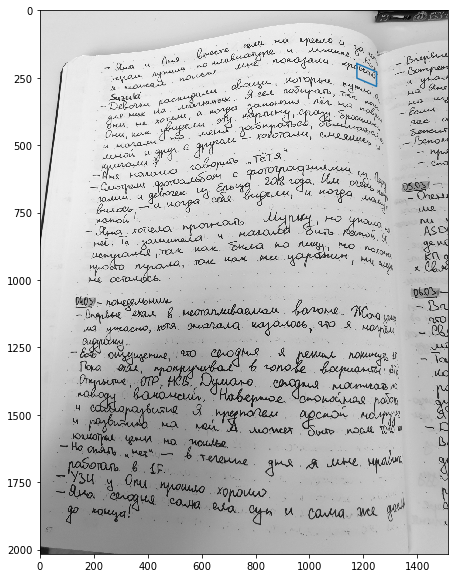

In [270]:
plt.figure(figsize=(10,10))
plt.imshow(srcr, cmap='gray')
plot_bbox(tmp_bbox)

In [95]:
tmp[45]-tmp[40]

0.014856780036708938

In [213]:
crv_p = extracted_lines[21][1]

((array([   0.        ,   25.95530639,   51.91061278,   77.86591916,
          103.82122555,  129.77653194,  155.73183833,  181.68714472,
          207.6424511 ,  233.59775749,  259.55306388,  285.50837027,
          311.46367666,  337.41898304,  363.37428943,  389.32959582,
          415.28490221,  441.2402086 ,  467.19551498,  493.15082137]),
  array([  75.2238806 ,  101.17918699,  127.13449337,  153.08979976,
          179.03860932,  204.51944012,  230.47406263,  256.42680449,
          281.90763529,  307.85832551,  333.34214827,  359.28728199,
          385.24258838,  411.19789477,  437.15320115,  463.10850754,
          488.93031228,  514.77669903,  540.73126078,  566.68656716]),
  array([ 1088.23880597,  1088.23880597,  1088.23880597,  1088.23880597,
          1088.1711621 ,  1083.23100102,  1083.2238806 ,  1083.25058211,
          1088.19074318,  1088.23880597,  1083.32979672,  1083.2238806 ,
          1083.2238806 ,  1083.2238806 ,  1083.2238806 ,  1083.2238806 ,
          1080